In [1]:
library(Seurat)
library(hdf5r)
library(dplyr)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.5 but the current
version is 1.7.1; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
path2datadir <- "/home/xinyuelu/AD-proj/spatial/H.Mathys_Xenium_12_2024"
path2figdir <- "/home/xinyuelu/AD-proj/spatial/figures-annotation"
path2resdir <- "/home/xinyuelu/AD-proj/spatial/results-annotation"
sample_id <- "20788853"
filename <- "cell_feature_matrix.h5"
batch <- "202412"

## Load sample data

In [3]:
data <- Read10X_h5(file.path(path2datadir, sample_id, filename), use.names = TRUE)  
obj <- CreateSeuratObject(counts = data)  

Genome matrix has multiple modalities, returning a list of matrices for this genome

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [4]:
cluster_data <- read.csv(paste0("/home/xinyuelu/AD-proj/spatial/H.Mathys_Xenium_12_2024/", sample_id,"/analysis/clustering/gene_expression_graphclust/clusters.csv"), header = TRUE)
umap_data <- read.csv(paste0("/home/xinyuelu/AD-proj/spatial/H.Mathys_Xenium_12_2024/", sample_id, "/analysis/umap/gene_expression_2_components/projection.csv"))

In [5]:
head(cluster_data) 
head(umap_data)

,Barcode,Cluster
,<chr>,<int>
1,aaaacojm-1,12
2,aaaaeabb-1,15
3,aaabjjbo-1,14
4,aaacndjb-1,15
5,aaadgigf-1,15
6,aaadmepe-1,11


,Barcode,UMAP.1,UMAP.2
,<chr>,<dbl>,<dbl>
1,aaaacojm-1,-7.501553,-3.892359
2,aaaaeabb-1,-6.015043,-6.594765
3,aaabjjbo-1,-2.977925,6.593545
4,aaacndjb-1,-6.173720,-6.696384
5,aaadgigf-1,-6.712194,-6.682459
6,aaadmepe-1,10.949985,1.738682


In [6]:
all(cluster_data$Barcode %in% colnames(obj)) 
all(umap_data$Barcode %in% colnames(obj)) 

[1] TRUE

[1] TRUE

In [7]:
all(cluster_data$Barcode == umap_data$Barcode)

[1] TRUE

In [8]:
obj <- subset(obj, cells = cluster_data$Barcode)

In [9]:
idents_vector <- setNames(cluster_data$Cluster, cluster_data$Barcode)
obj <- SetIdent(obj, cells = cluster_data$Barcode, value = idents_vector)

In [10]:
cluster_data <- cluster_data[cluster_data$Barcode %in% colnames(obj), ]

In [11]:
umap_matrix <- as.matrix(umap_data[, c("UMAP.1", "UMAP.2")])
rownames(umap_matrix) <- umap_data$Barcode

obj[["umap"]] <- CreateDimReducObject(
  embeddings = umap_matrix,
  key = "UMAP_",
  assay = DefaultAssay(obj)
)

In [12]:
print(head(Idents(obj)))
print(head(Embeddings(obj, "umap")))

aaaacojm-1 aaaaeabb-1 aaabjjbo-1 aaacndjb-1 aaadgigf-1 aaadmepe-1 
        12         15         14         15         15         11 
28 Levels: 12 15 14 11 23 5 9 8 20 13 2 21 22 4 3 24 19 17 1 25 6 10 7 ... 28
              UMAP_1    UMAP_2
aaaacojm-1 -7.501553 -3.892359
aaaaeabb-1 -6.015043 -6.594765
aaabjjbo-1 -2.977925  6.593545
aaacndjb-1 -6.173720 -6.696384
aaadgigf-1 -6.712194 -6.682459
aaadmepe-1 10.949985  1.738682


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



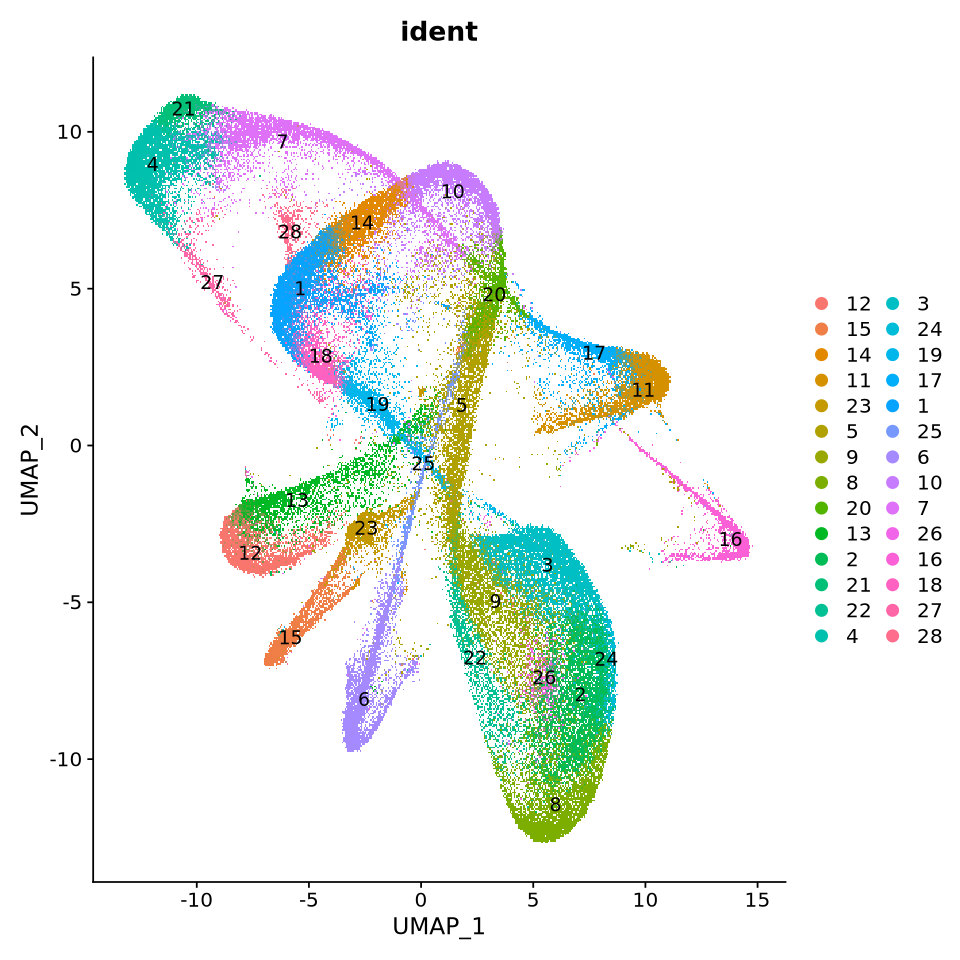

In [13]:
saved <- options(repr.plot.width=8, repr.plot.height=8)
DimPlot(obj, reduction = "umap", group.by = "ident", label = TRUE)
options(saved)

## Major cell type annotation

In [14]:
plot_markers = function(obj, features, title, sort_order = NULL, width=8, height=8) {
    if (!is.null(sort_order)) {
        Idents(obj) <- factor(Idents(obj), levels = sort_order)
    }
    p <- DotPlot(obj, features=features) + ggtitle(title) + 
    theme_classic() + 
    theme(plot.title = element_text(size = 12)) + 
    theme(axis.text.x = element_text(size = 12, angle = 45, hjust = 1))
    p <- p + scale_color_distiller(palette = "RdBu")
    print(p)
    for (suffix in c('png', 'pdf')) {
        path2file = file.path(path2figdir, paste0('markergene-dot-', title, '.', suffix))
        print(path2file)
        ggsave(path2file, p, width=width, height=height, dpi=500)
    }
}

In [15]:
max_ident <- max(as.numeric(unique(Idents(obj))))
print(max_ident)
sort_order <- as.character(1:max_ident)

[1] 28


In [16]:
genes.major = c(
    "NRGN", "SYT1", "SNAP25", "GRIN1", "SLC17A7", "CAMK2A", "CBLN2", # Exc
    "GAD1", "GAD2", "DPP10", "RELN", # Inh
    "AQP4", "GFAP", "GPC5", "SLC1A2", "ADGRV1", "SLC1A3",# Astro
    "MBP", "MOBP", "PLP1", "ST18", "LINC00609", "OSP", "MOG", "CNP", # Oligo
    "CSF1R", "CD74", "C3", "SRGN", "HS3ST4", "LRMDA", "F13A1", # Micro
    "VCAN", "PDZRN4", # OPC
    "TSHZ2", "ADAMTS9", "ABCB1","FLT1", "CLDN5",  # Endo
    "RGS5", "ACTA2", "AMBP", "CD146", "PDGFA", "ANPEP", "DES", "ABCC9", "NOTCH3", # Per
    "COL1A1", "COL1A2", "COLEC12", # VLMC
    "SOX10", # Oligo, OPC, Per
    "PDGFRA", # OPC, VLMC
    "PDGFRB", # Per, VLMC
    "CSPG4" # OPC, Per
)

In [17]:
Idents(obj) <- factor(Idents(obj), levels = sort_order)

Warning message:
“No layers found matching search pattern provided”
Warning message in FetchData.Assay5(object = object[[DefaultAssay(object = object)]], :
“data layer is not found and counts layer is used”
Warning message:
“The following requested variables were not found (10 out of 29 shown): NRGN, SYT1, CBLN2, DPP10, GFAP, GPC5, ADGRV1, MBP, MOBP, PLP1”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


[1] "/home/xinyuelu/AD-proj/spatial/figures-annotation/markergene-dot-major-cell-types-spatial-20788853-raw.png"
[1] "/home/xinyuelu/AD-proj/spatial/figures-annotation/markergene-dot-major-cell-types-spatial-20788853-raw.pdf"


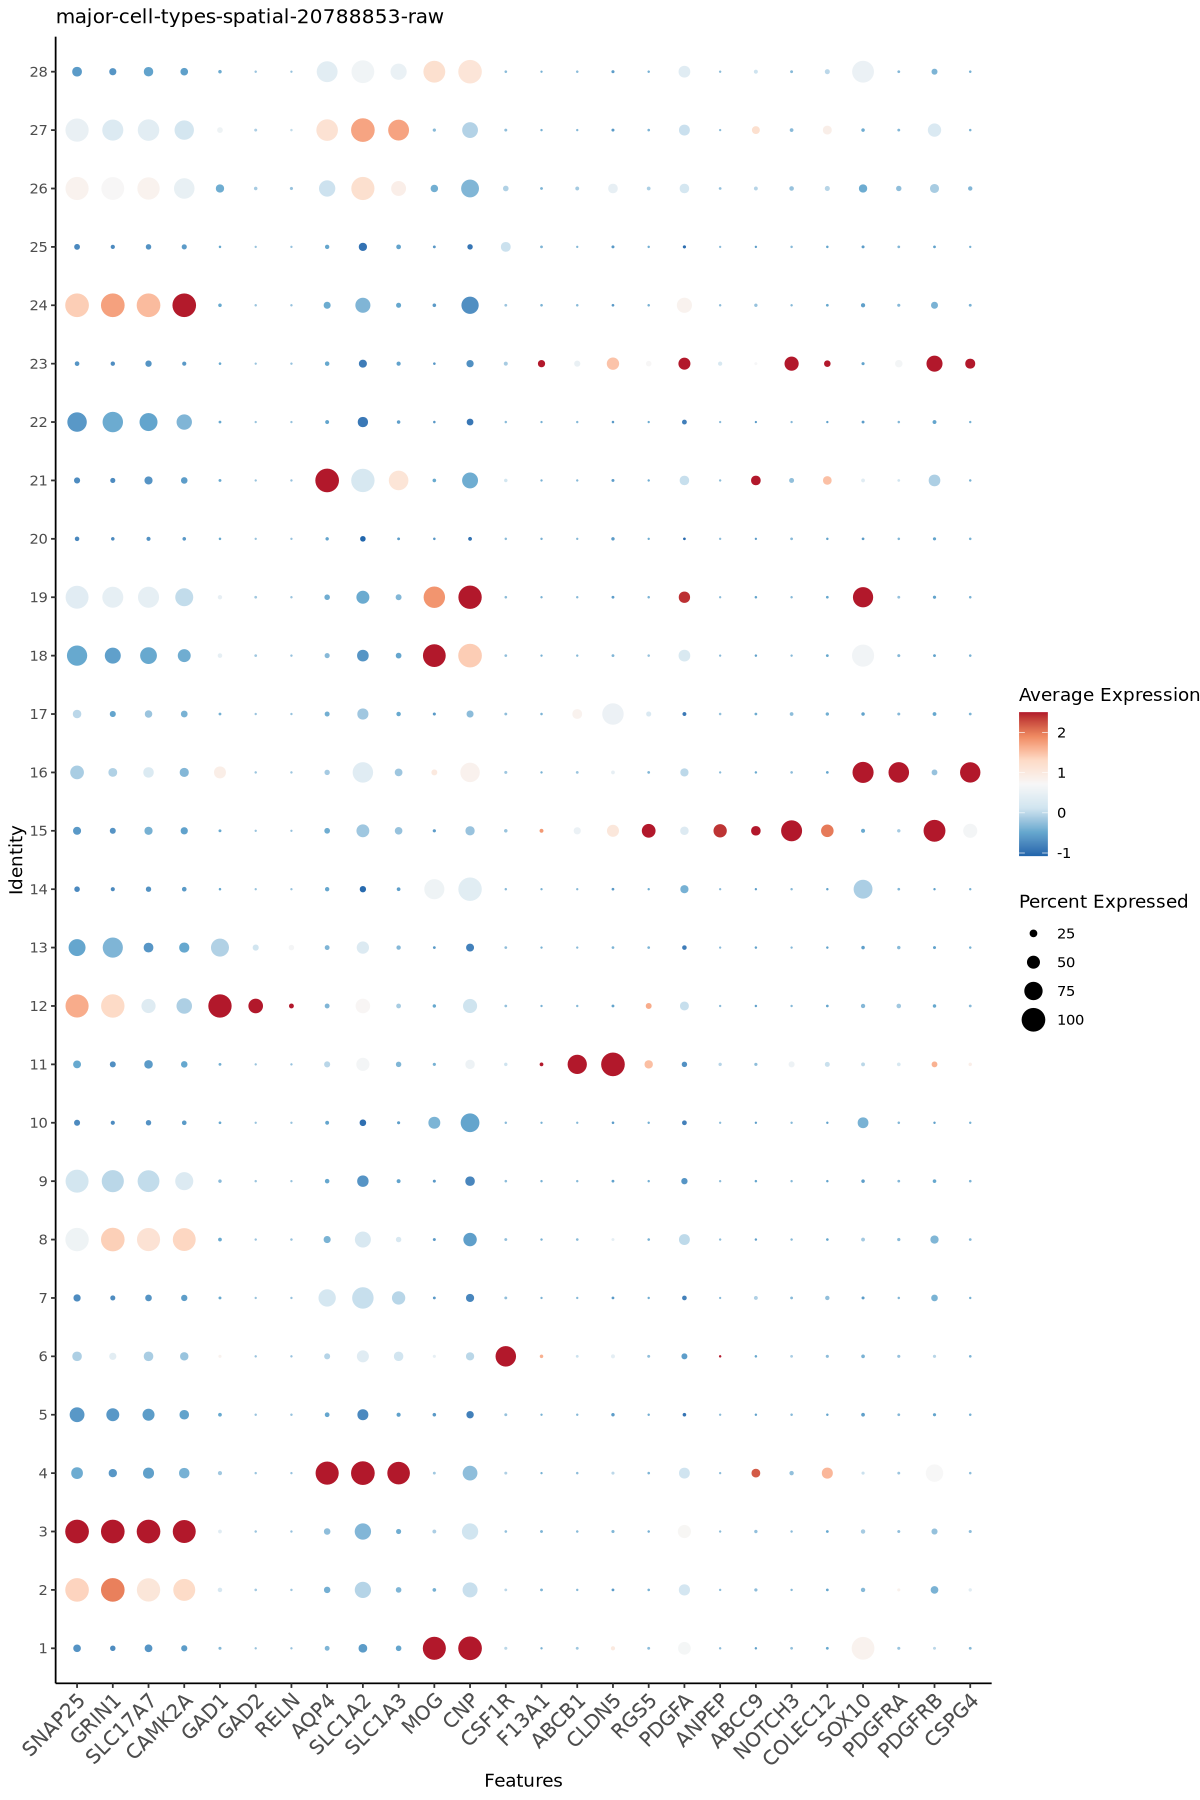

In [18]:
saved <- options(repr.plot.width=10, repr.plot.height=15)
plot_markers(obj, genes.major, paste0("major-cell-types-spatial-", sample_id, "-raw"))
options(saved)

In [19]:
obj.processed <- obj

In [20]:
obj <- obj.processed
obj <- RenameIdents(object = obj, `1` = "Oligo") # ok
obj <- RenameIdents(object = obj, `2` = "Exc") # ok
obj <- RenameIdents(object = obj, `3` = "Exc") # ok
obj <- RenameIdents(object = obj, `4` = "Astro") # ok 
obj <- RenameIdents(object = obj, `5` = "Mix-Lowexpr") # ok
obj <- RenameIdents(object = obj, `6` = "Micro") # ok
obj <- RenameIdents(object = obj, `7` = "Astro-Lowexpr") # ok
obj <- RenameIdents(object = obj, `8` = "Exc") # ok 
obj <- RenameIdents(object = obj, `9` = "Exc-Lowexpr") # ok
obj <- RenameIdents(object = obj, `10` = "Oligo-Lowexpr") # ok
obj <- RenameIdents(object = obj, `11` = "Endo") # ok
obj <- RenameIdents(object = obj, `12` = "Inh") # ok
obj <- RenameIdents(object = obj, `13` = "Inh-Lowexpr") # ok
obj <- RenameIdents(object = obj, `14` = "Oligo-Lowexpr") # ok
obj <- RenameIdents(object = obj, `15` = "VLMC") # ok 
obj <- RenameIdents(object = obj, `16` = "OPC") # ok
obj <- RenameIdents(object = obj, `17` = "Endo-Lowexpr") # ok
obj <- RenameIdents(object = obj, `18` = "Oligo") # ok
obj <- RenameIdents(object = obj, `19` = "Oligo") # ok 
obj <- RenameIdents(object = obj, `20` = "Mix-Lowexpr") # ok
obj <- RenameIdents(object = obj, `21` = "Astro") # ok
obj <- RenameIdents(object = obj, `22` = "Exc-Lowexpr") # ok 
obj <- RenameIdents(object = obj, `23` = "Per") # ok
obj <- RenameIdents(object = obj, `24` = "Exc") # ok
obj <- RenameIdents(object = obj, `25` = "Mix-Lowexpr") # ok 
obj <- RenameIdents(object = obj, `26` = "Exc") # ok
obj <- RenameIdents(object = obj, `27` = "Astro") # ok
obj <- RenameIdents(object = obj, `28` = "Oligo-Lowexpr") # ok
obj.main <- obj

In [23]:
base_colors <- c(
    "Exc" = "turquoise4", 
    "Exc-Lowexpr" = "turquoise2", 
    "Inh" = "deeppink4", 
    "Inh-Lowexpr" = "deeppink1", 
    "Astro" = "orchid4",
    "Astro-Lowexpr" = "orchid2", 
    "Oligo" = "yellow3", 
    "Oligo-Lowexpr" = "yellow1", 
    "Micro" = "steelblue4", 
    "OPC" = "springgreen4",
    "Endo" = "bisque4", 
    "Endo-Lowexpr" = "bisque2",
    "VLMC" = "palegreen3",
    "Per" = "lightsalmon",
    "Mix-Lowexpr" = "dimgrey"

)

obj <- obj.main
Idents(obj) <- factor(Idents(obj), levels = names(base_colors))

Warning message:
“No layers found matching search pattern provided”
Warning message in FetchData.Assay5(object = object[[DefaultAssay(object = object)]], :
“data layer is not found and counts layer is used”
Warning message:
“The following requested variables were not found (10 out of 29 shown): NRGN, SYT1, CBLN2, DPP10, GFAP, GPC5, ADGRV1, MBP, MOBP, PLP1”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


[1] "/home/xinyuelu/AD-proj/spatial/figures-annotation/markergene-dot-major-cell-types-spatial-20788853.png"
[1] "/home/xinyuelu/AD-proj/spatial/figures-annotation/markergene-dot-major-cell-types-spatial-20788853.pdf"


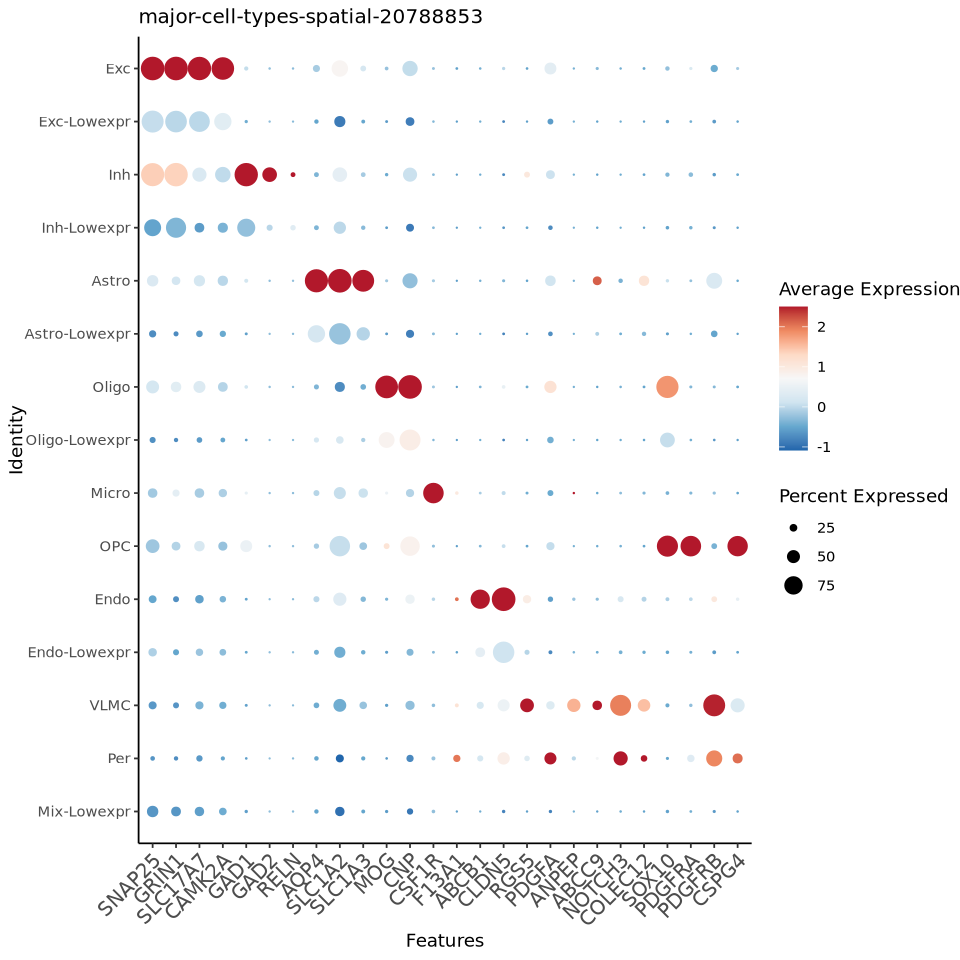

In [24]:
saved <- options(repr.plot.width=8, repr.plot.height=8)
plot_markers(obj, genes.major, paste0("major-cell-types-spatial-", sample_id), sort_order = rev(names(base_colors)))
options(saved)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



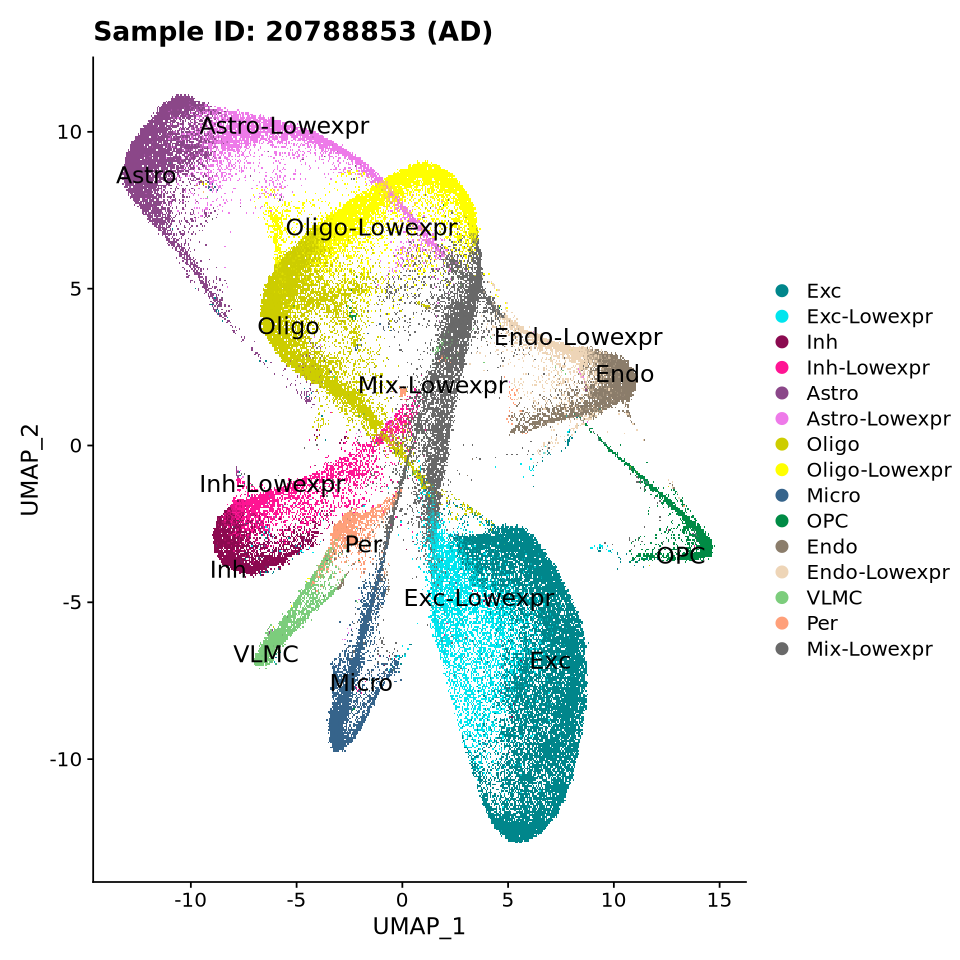

In [25]:
saved <- options(repr.plot.width=8, repr.plot.height=8)
p <- DimPlot(obj, label = TRUE, repel = TRUE, label.size = 5, cols = base_colors) + ggtitle("Sample ID: 20788853 (AD)")
print(p)
options(saved)

filename <- file.path(path2figdir, paste0("UMAP-cell-type-annotation-", sample_id, ".png"))
ggsave(filename = filename, width = 10, height = 8, dpi=500)

In [26]:
path2file = file.path(path2resdir, paste0("major-celltype-info-Seurat-", sample_id, ".csv"))
print(path2file)
write.csv(data.frame(Idents(obj)), path2file)

[1] "/home/xinyuelu/AD-proj/spatial/results-annotation/major-celltype-info-Seurat-20788853.csv"


## Load position information

In [27]:
filename <- "cells.csv.gz"
meta_list <- list()

sample_meta <- read.csv(gzfile(file.path(path2datadir, sample_id, filename)))

<Guides[1] ggproto object>

colour : <GuideLegend>

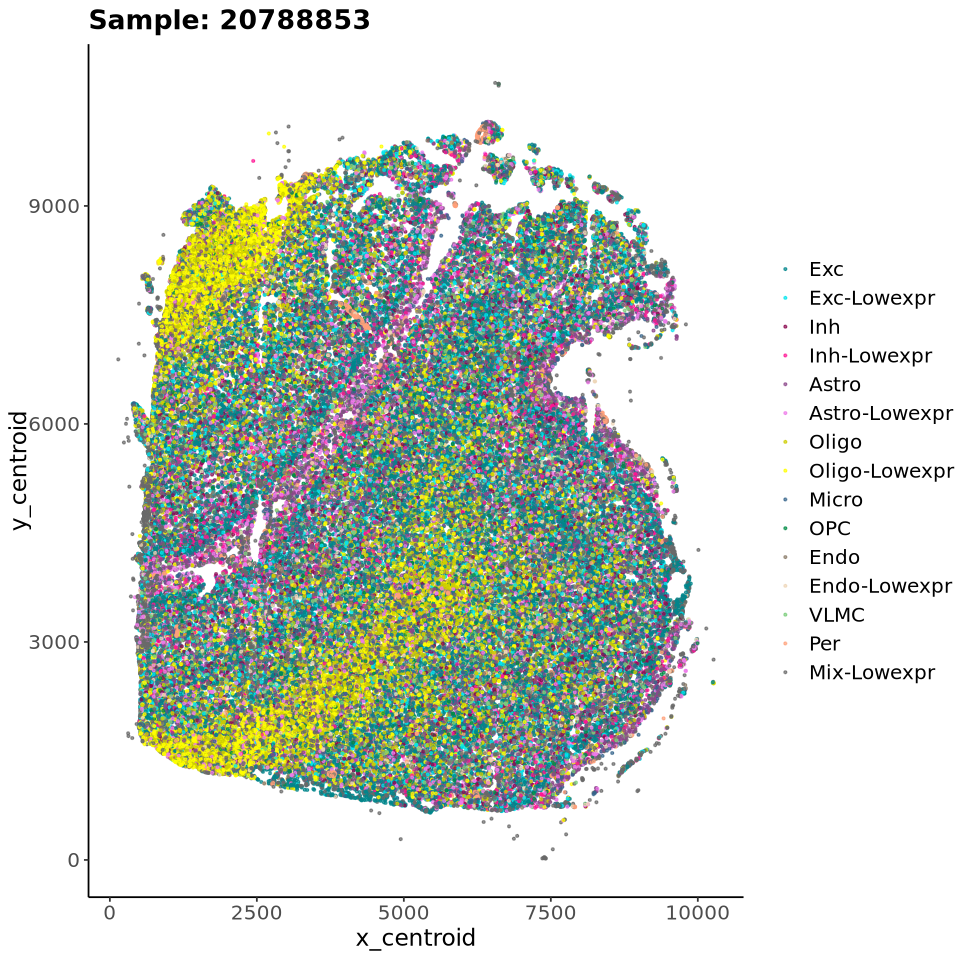

In [30]:
rownames(sample_meta) <- sample_meta$cell_id
sample_meta$Cluster <- Idents(obj.main)[rownames(sample_meta)]
sample_meta <- sample_meta[!is.na(sample_meta$Cluster), ]

saved <- options(repr.plot.width=8, repr.plot.height=8)
p <- ggplot(sample_meta, aes(x = x_centroid, y = y_centroid, color = as.factor(Cluster))) +
    geom_point(alpha = 0.7, size = 0.5) +
    scale_color_manual(values = base_colors, breaks = names(base_colors)) +
    labs(title = paste("Sample:", sample_id), color = "Cluster") +
    theme_classic() +
    theme(
        plot.title = element_text(size = 16, face = "bold"),
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12),
        legend.title = element_blank(), 
        legend.text = element_text(size = 12),
        legend.position = "right"
    )
    guides(color = guide_legend(override.aes = list(size = 30)))

filename <- file.path(path2figdir, paste0("Per-slice-cell-type-annotation-", sample_id, ".png"))
ggsave(filename = filename, width = 10, height = 8, dpi=500)

print(p)
options(saved)

In [32]:
rownames(sample_meta) <- paste0(sample_id, "_", rownames(sample_meta))
sample_meta <- sample_meta[,c("x_centroid", "y_centroid", "cell_area","nucleus_area", "Cluster")]
write.csv(sample_meta, file.path(path2resdir, paste0(sample_id, "_celltype_coordinates.csv")), row.names = TRUE)

## Classify subclass (GABAergic/Glutamatergic/Glial)

In [34]:
set_gaba <- c("Exc", "Exc-Lowexpr") 
set_glu <- c("Inh", "Inh-Lowexpr") 
set_glia <- c("Oligo", "Oligo-Lowexpr", "Astro", "Astro-Lowexpr", "Micro", "OPC", "Endo", "VLMC", "Per") 

sample_meta$class_label <- ifelse(sample_meta$Cluster %in% set_gaba, "GABAergic",
                           ifelse(sample_meta$Cluster %in% set_glu, "Glutamatergic",
                           ifelse(sample_meta$Cluster %in% set_glia, "Glial", NA)))

sample_meta <- sample_meta[!is.na(sample_meta$class_label), ]

In [35]:
subclass_colors <- c(
    "GABAergic" = "turquoise4", 
    "Glutamatergic" = "deeppink4", 
    "Glial" = "yellow2"
)

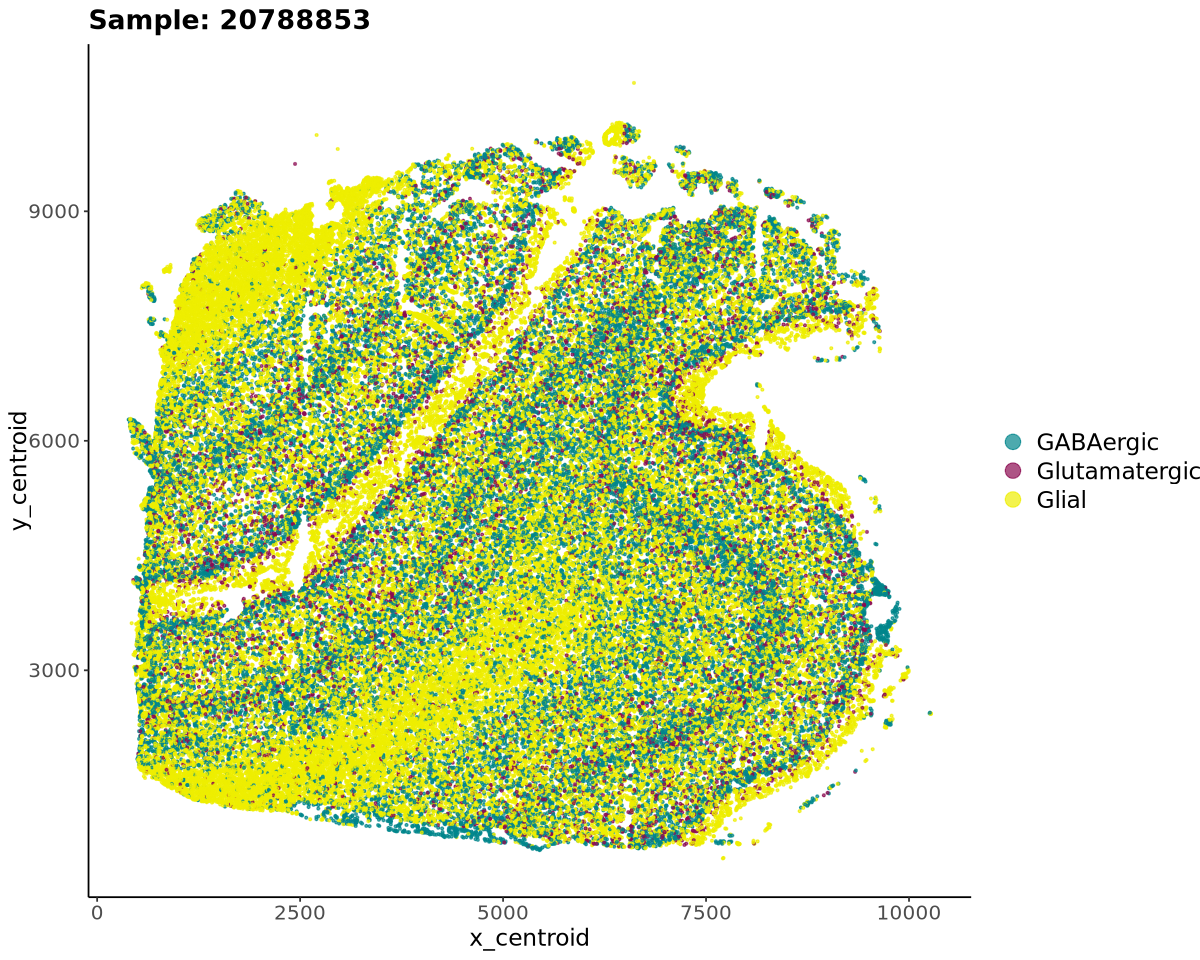

In [37]:
saved <- options(repr.plot.width=10, repr.plot.height=8)

p <- ggplot(sample_meta, aes(x = x_centroid, y = y_centroid, color = class_label)) +
    geom_point(alpha = 0.7, size = 0.5) +
    scale_color_manual(values = subclass_colors, breaks = names(subclass_colors)) +  
    ggtitle(paste("Sample:", sample_id)) +
    theme_classic() +
    theme(
        plot.title = element_text(size = 16, face = "bold"),
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12),
        legend.title = element_blank(), 
        legend.text = element_text(size = 14), 
        legend.position = "right",
    
    ) +
    guides(color = guide_legend(override.aes = list(size = 4)))  

filename <- file.path(path2figdir, paste0("Per-slice-subclass-", sample_id, ".png"))
ggsave(filename = filename, width = 10, height = 8, dpi=500)

print(p)

options(saved)

## Check RNA expression

In [38]:
obj <- obj.main
desired_order <- names(base_colors)
Idents(obj) <- factor(Idents(obj), levels = desired_order)
print(levels(Idents(obj)))

 [1] "Exc"           "Exc-Lowexpr"   "Inh"           "Inh-Lowexpr"  
 [5] "Astro"         "Astro-Lowexpr" "Oligo"         "Oligo-Lowexpr"
 [9] "Micro"         "OPC"           "Endo"          "Endo-Lowexpr" 
[13] "VLMC"          "Per"           "Mix-Lowexpr"  


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


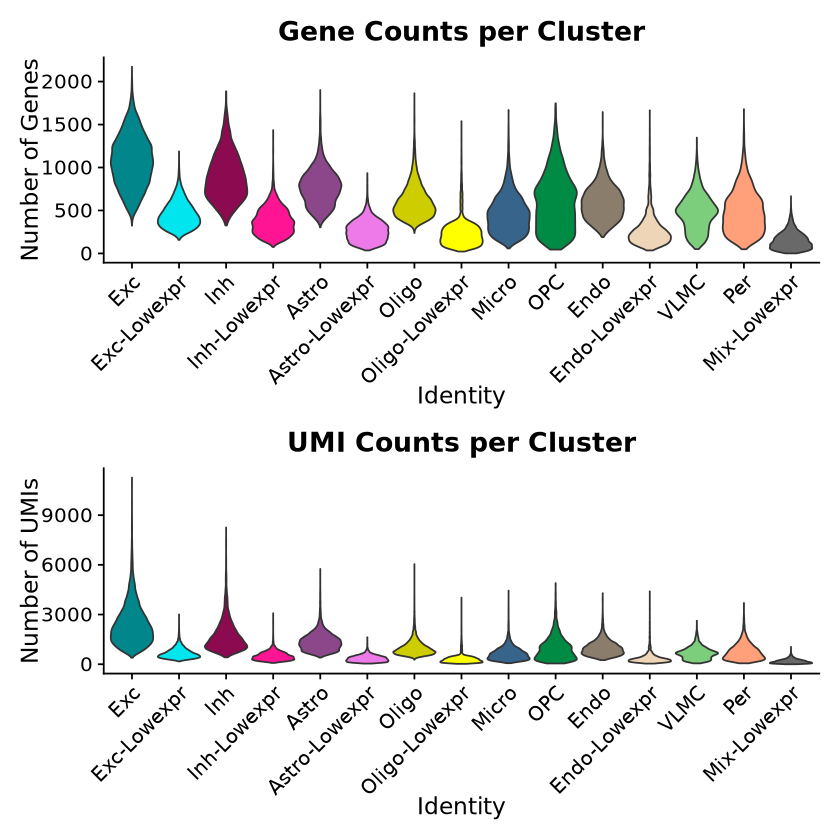

In [39]:
p1 <- VlnPlot(obj, features = "nFeature_RNA", pt.size = 0, cols = base_colors) +
  ggtitle("Gene Counts per Cluster") +
  ylab("Number of Genes") +
  theme(legend.position = "none") 

p2 <- VlnPlot(obj, features = "nCount_RNA", pt.size = 0, cols = base_colors) +
  ggtitle("UMI Counts per Cluster") +
  ylab("Number of UMIs") +
  theme(legend.position = "none")  

combined_plot <- p1 + p2

filename <- file.path(path2figdir, paste0("gene-umi-dist-major-celltype-", sample_id, ".png"))
ggsave(filename = filename, width = 10, height = 8, dpi=500)

print(combined_plot)